# Magnipy Tutorial

This tutorial will walk you through using some of the main functionalities of the `Magnipy` package, which is used to compute and compare the magnitude (effective size) of point clouds.

## Tutorial overview:
1. **Importing** required packages and datasets
    - Dataset #1: Random Point Cloud
    - Dataset #2: Clusters/Blobs
    - Dataset #3: Swiss roll
2. **Core functionality**: Computing magnitude functions
3. **Zooming in**: Breakdown of magnitude pipeline
    - Determining convergence scales and evaluation intervals
    - Computing distance matrix
    - Creating similarity matrix
    - Computing magnitude weights
4. **Diversity summaries:** MagArea and MagDiff

### 1. Importing Packages and Datasets

#### Imports
Before we begin, we must import the packages required for our functionality.

Please ensure that you have activated your virtual environment and installed the dependencies using poetry before this step (see **Dependencies** in the README).

In [1]:
# import statements for external packages
from importlib import reload
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# import statements from magnipy repo
from magnipy.magnipy import Magnipy
from tutorial_data import *

#### Example Datasets

We create 3 example datasets according to different distributions, each with 1000 points.

**1. Random Point Cloud from Uniform Distribution**

Here, we generate random points in a 3D space (i.e. selecting points according to a uniform distribution so that any point is chosen with equal probability.)

**2. Clusters/Blobs**

Here, we generate a dataset clustered around 5 points.

**3. The Swiss Roll**

The Swiss Roll is a classic generated dataset that roughly takes the shape of a 2D plane that has been rolled in a spiral, forming a 3D manifold. Here, we use it as a toy example to demonstrate the functionality of our magnipy package.

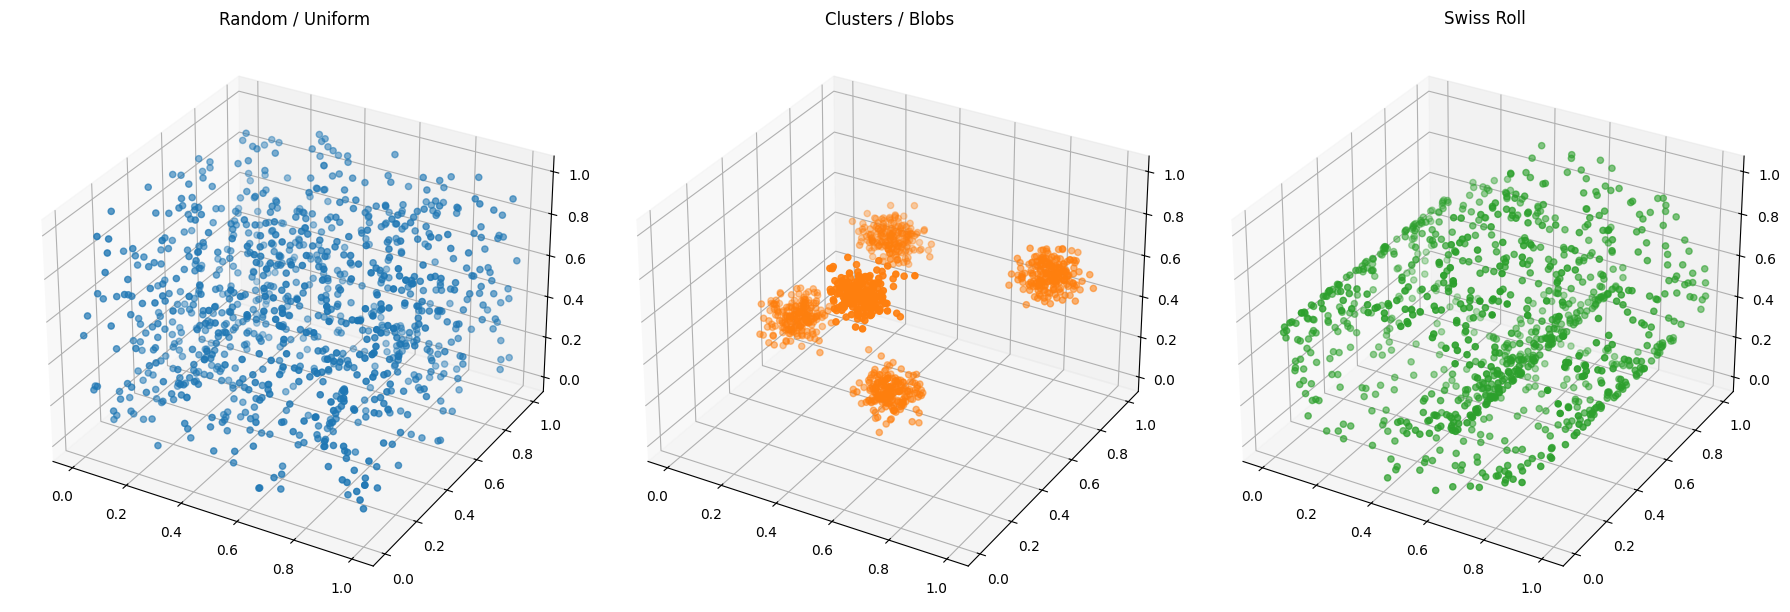

In [3]:
# Grabbing datasets
rando_data, rando_df = get_random()
blobs_data, blobs_df = get_clusters()
sr_data, sr_df = get_swiss_roll()
# Plotting
plot_dfs([rando_df, blobs_df, sr_df], titles=["Random / Uniform", "Clusters / Blobs", "Swiss Roll"])

### 2. Computing Magnitude

For each dataset, we then compute the magnitude functions as follows.

We first create the Magnipy object for each datset, which we will use to call our magnitude methods.


In [4]:
# Creating a Magnipy instance for each dataset
rando = Magnipy(rando_data, name='Random')
blobs = Magnipy(blobs_data, name='Clustered/Blobs')
swiss_roll = Magnipy(sr_data, name='Swiss Roll')
mags = [rando, blobs, swiss_roll]

We can now call the Magnipy methods on each of these instances.

Computing and visualizing the magnitude across distance scales is as simple as calling the `plot_magnitude_function()` method.

Text(0.5, 1.0, 'Plotting Magnitude with Magnipy')

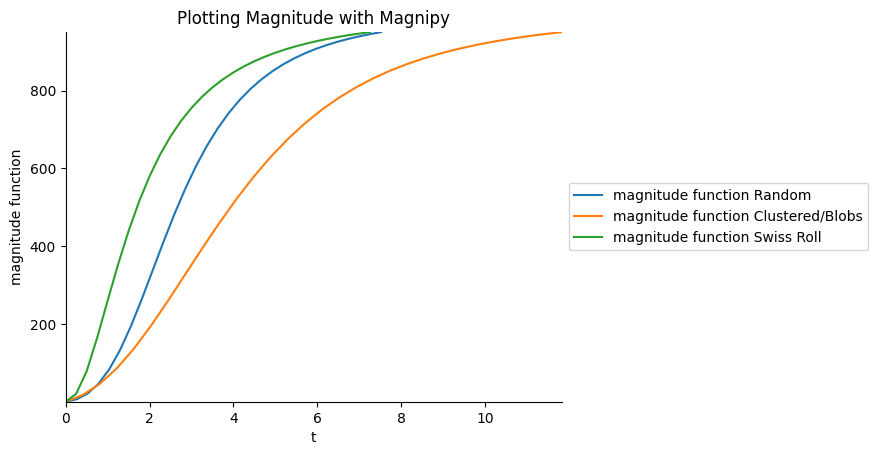

In [5]:
# Plotting magnitude
for mag in mags:
    mag.plot_magnitude_function()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.autoscale(enable=True, axis='both', tight=True)
plt.title("Plotting Magnitude with Magnipy")

Recall that **t** is our distance scaling factor. This means any pairwise distance between points is scaled by a factor of t. We can visualize an increase in **t** as 'zooming in', where points spread further away from each other.

When **t** is 0, the points have distance 0 from each other, and thus are effectively 1 point.

As **t** increases, we 'zoom in' and the distance between points increases as they spread out. Thus the magnitude / effective size also increases.

Finally, **t** plateaus at the cardinality of the dataset, in this case 1000.

By default, we compute magnitude until it reaches 95% of the cardinality. (See section _"Determining Convergence Scales and Evaluation Intervals"_ below).

### 3. Zooming In: Breakdown of Magnitude Pipeline

How does Magnipy compute magnitude? In this section, we walk through the process step by step:

- 3A. Determining Convergence Scales and Evaluation Intervals

#### 3A. Determining Convergence Scales and Evaluation Intervals

**_Q: How does Magnipy decide which values of **t** to compute magnitude for?_**

By default, we automatically estimate the **convergence scale** for a space: that is, when the magnitude will reach 95% of its cardinality.

In [6]:
# Get convergence scale with .get_t_conv()
for mag in mags:
    print(f"{mag.get_name()} dataset converges at: {mag.get_t_conv():.2f}.")


Random dataset converges at: 7.52.
Clustered/Blobs dataset converges at: 11.82.
Swiss Roll dataset converges at: 7.25.


Recall that when we plotted the magnitude functions, the random and swiss roll datasets converged towards their cardinality much faster than that of the clusters dataset. Thus, we expect their convergence scales to be much lower. This idea is confirmed by the convergence scales of the three datasets.

We define each function's **evaluation interval** from zero until this convergence scale, and divide it evenly into `n_ts` values (default=100).

In [7]:
# Get evaluation interval for with .get_scales()
rando_ts = rando.get_scales()
print(f"Evaluation interval for Dataset #1: [{rando_ts[0]:.2f}, {rando_ts[1]:.2f}, {rando_ts[2]:.2f}, ..., {rando_ts[-1]:.2f}].")

Evaluation interval for Dataset #1: [0.00, 0.26, 0.52, ..., 7.52].


##### Customizing Evaluation Scales

There are other ways to customize the way that evaluation scales are computed when creating a Magnipy object, including:

- Manually entering t values via the `ts` parameter (default = None)
- Altering the number of t values  via the `n_ts` parameter (default = 100)
- Using a log scale by setting `log_scale = True` (default = False)
- Changing the proportion of cardinality the magnitude function converges to via `target_prop` (default = 0.95)
- Changing the method from "convergence" to "scattered" via the `scale_finding` parameter (default = "convergence")

See the `magnipy.py` file for descriptions of all evaluation scale parameters.

#### 3B. Computing the Distance Matrix

Recall the **t** is a scaling factor for the distance between points in the metric space.

We compute a distance matrix that stores the pairwise distances between points in the metric space. (The dimensions of this matrix are |X| by |X|)

This can then be easily scaled by our scaling factor **t**.

In [8]:
# Computing distance matrix with get_dist()
rando_dist = rando.get_dist()
blob_dist = blobs.get_dist()
swiss_dist = swiss_roll.get_dist()

We can visualize these distance matrices below, with the x- and y- axes representing the index of each point in the dataset.

Small distances are represented in dark purple and large distances in light green.

Note that distance when x=y (i.e. distance between a point and itself) is always 0.

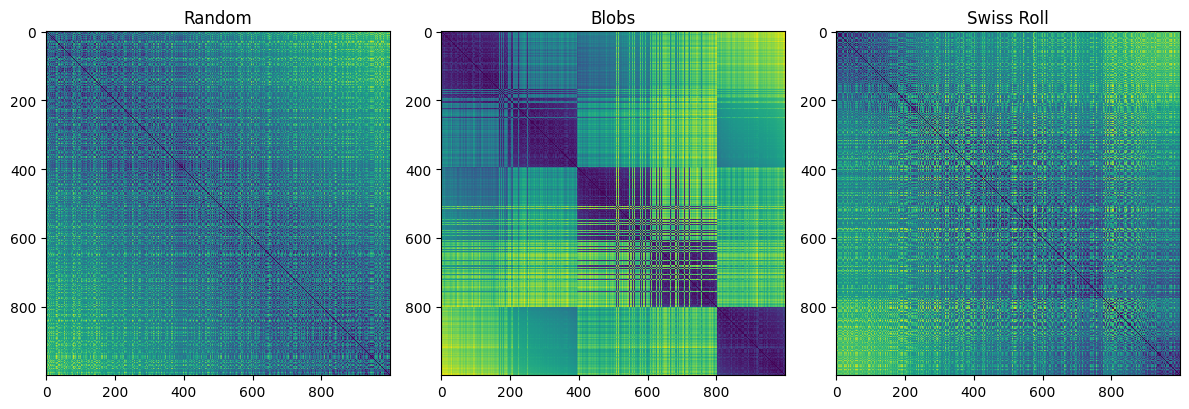

In [9]:
# Visualization of distance matrices

plot_matrices([rando_dist, blob_dist, swiss_dist], 
              ["Random", "Blobs", "Swiss Roll"])

##### Customizing Distance Calculation

When initializing the Magnipy object, you can customize which distance metric you want to use.

The default is to use Euclidean distance. See `magnipy.py` for a complete list of all supported metrics.



#### 3C. Creating the Similarity Matrix

The distance and similarity of two points _a_ and _b_ are related in the following way:

similarity(_a, b_) = _e_^(-distance(_a,b_))

That is, the further two points are from each other (i.e. the larger the distance between them), the less "similar" they are.

We use this simple relationship to calculate the similarity matrix from the distance matrix.

In [10]:
# Computing similarity matrices
rando_sim = rando.get_similarity_matrix()
blobs_sim = blobs.get_similarity_matrix()
swiss_sim = swiss_roll.get_similarity_matrix()


We can visualize these similarity matrices similarly to how we visualized distance.

Low similarity are represented in dark purple and higher similarity in yellow.

There less variation in color because similarity values fall between 0 and 1.

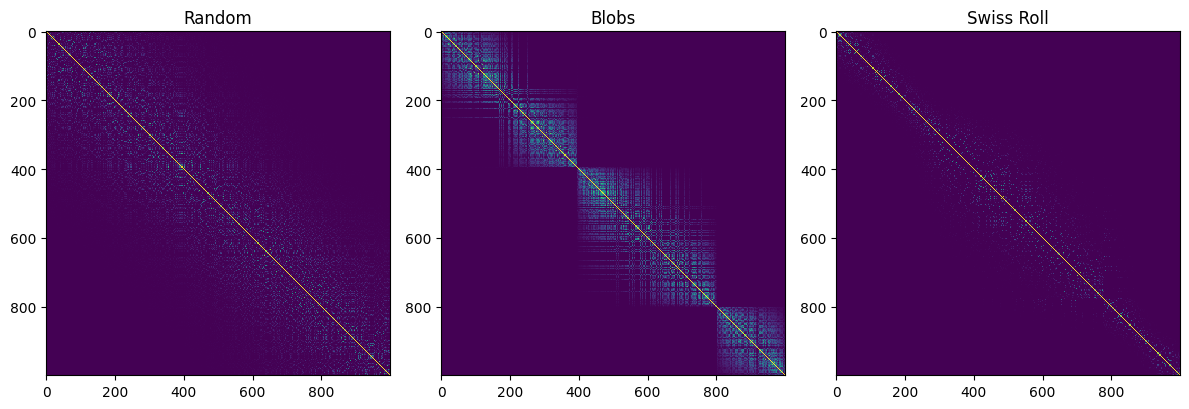

In [20]:
# Visualizing similarity matrices
plot_matrices([rando_sim, blobs_sim, swiss_sim], 
              ["Random", "Blobs", "Swiss Roll"])

#### 3D. Computing Magnitude Weights

# TODO

### 4. Diversity Summaries: MagArea and MagDiff

We can use **magnitude** - which measures the effective number of distinct points at at a distance scale **t** - as metric for quantifying the diversity of a metric space.

#### MagArea: Intrinsic Diversity

Our metric for the **intrinsic diversity** of each space is **MagArea**, the area under each magnitude function. The higher the MagArea, the more diverse the space.

We can use this to for comparison between datasets evaluated across the same scales of distances i.e. using the same evaluation interval. 

MagArea of RANDOM evaluated across [0.0, 7.52] equals 4457.5
MagArea of CLUSTERED/BLOBS evaluated across [0.0, 7.52] equals 3337.57
MagArea of SWISS ROLL evaluated across [0.0, 7.52] equals 5231.47


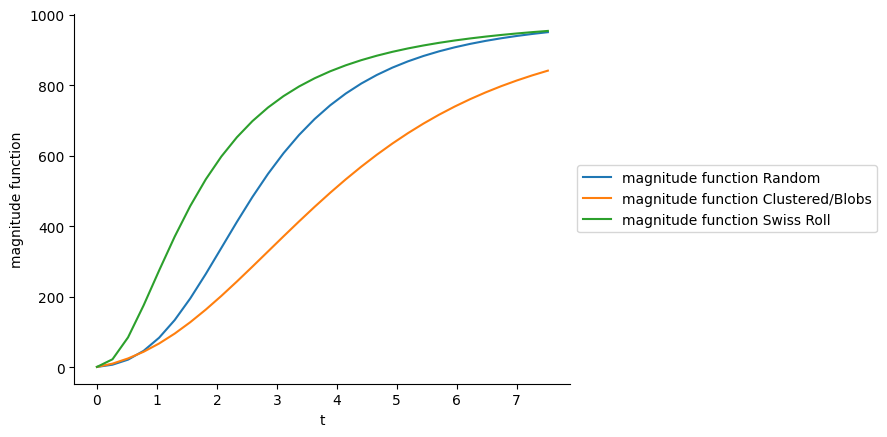

In [21]:
# Choosing same evaluation interval
t_cut = mags[0].get_t_conv()

for i, Mag in enumerate(mags):
    # Changing evaluation interval to match
    Mag.change_scales(t_cut=t_cut)
    ts=Mag.get_scales()
    # Plotting with new evaluation interval
    Mag.plot_magnitude_function()
    # Getting magnitude with new evaluation interval
    mag, ts = Mag.get_magnitude()
    # Mag Area
    mag_area = Mag.MagArea(absolute_area=True)
    print(f"MagArea of {Mag.get_name().upper()} evaluated across [{round(ts[0],2)}, {round(ts[-1],2)}] equals {round(mag_area,2)}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### MagDiff

Further, we can conduct more detailed comparisons by taking **MagDiff**, the area between two magnitude functions, as a measure of dissimilarity.

We compare each space's magnitude to the Swiss Roll, the most diverse space with the highest magnitude, and plot the absolute MagDiff across each scale.

MagDiff (Swiss Roll - Random) evaluated between [0,7.52] equals 773.98
MagDiff (Swiss Roll - Clustered/Blobs) evaluated between [0,7.52] equals 1893.9
MagDiff (Swiss Roll - Swiss Roll) evaluated between [0,7.52] equals 0.0


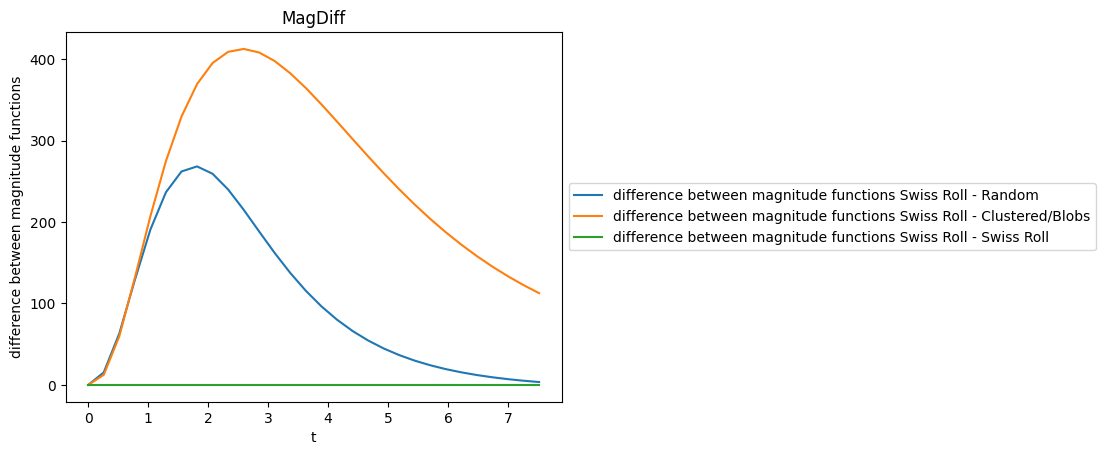

In [22]:
# selecting the swiss roll as a comparison point
Mag0=mags[2]

for Mag in mags:
    mag_diff = Mag0.MagDiff(Mag, scale=False, t_cut=t_cut, plot=True, absolute_area=False)
    print(f"MagDiff ({Mag0.get_name()} - {Mag.get_name()}) evaluated between [0,{round(t_cut,2)}] equals {round(mag_diff,2)}")
    plt.title("MagDiff")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))